In [1]:
import sys 
sys.executable

'/Users/lukaszmarchlewicz/Desktop/Portfolio/witcher_project/bin/python3'

In [2]:
import os
import pandas as pd
import numpy as np
import spacy
from spacy import displacy

import networkx as nx

import matplotlib.pyplot as plt

In [3]:
#!python3 -m spacy download en_core_web_sm

In [4]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

In [5]:
all_books = [i for i in os.scandir('../input') if '.txt' in i.name]

In [6]:
all_books

[<DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '1 The Last Wish.txt'>,
 <DirEntry '8 something ends something begins.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>]

In [7]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [8]:
# Visualize identified entities
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

### Load character names

In [9]:
# Read characters
character_df = pd.read_csv("../output/characters.csv")

In [10]:
# Remove brackets and text within brackets
import re 
character_df['character'] = character_df['character'].apply( lambda x : re.sub("[\(].*?[\)]","", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [11]:
character_df

,Unnamed: 0,book_name,character,character_firstname
0,0,Category:Baptism of Fire characters,Adalia,Adalia
1,1,Category:Baptism of Fire characters,Adela,Adela
2,2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,4,Category:Baptism of Fire characters,Aglaïs,Aglaïs
...,...,...,...,...
1270,1270,Category:Time of Contempt characters,Yanna of Murivel,Yanna
1271,1271,Category:Time of Contempt characters,Yarpen Zigrin,Yarpen
1272,1272,Category:Time of Contempt characters,Yennefer of Vengerberg,Yennefer
1273,1273,Category:Time of Contempt characters,Yiolenta Suarez,Yiolenta


### Get named entity list per sentence

In [12]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [13]:
sent_entity_df.shape

(10364, 2)

In [14]:
sent_entity_df.head()

,sentence,entities
0,"(﻿Verily, I, say, unto, you, ,, the, era, of, ...",[]
1,"(The, Time, \n, of, the, White, Chill, and, th...","[Time, the White Chill, the White Light, the T..."
2,"(The, world, will, die, amidst, frost, and, be...",[]
3,"(It, will, be, reborn, of, the, Elder, Blood, ...",[Ichaer]
4,"(A, seed, which, \n, will, not, sprout, but, w...",[]


In [15]:
sent_entity_df.loc[1].sentence

The Time 
of the White Chill and the White Light is nigh, the Time of Madness and the Time of Contempt: 
Tedd Deireddh, the Time of End.

In [16]:
print(sent_entity_df.loc[1].entities)

['Time', 'the White Chill', 'the White Light', 'the Time of Madness', 'the Time of Contempt', 'Tedd Deireddh', 'the Time of End']


In [17]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [18]:
filter_entity(["Geralt", "Lukasz", "2"], character_df)

['Geralt']

In [19]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, Aen Seidhe, the Blood of Elves, Aen It...",[Aevenien]
71,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
135,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
161,"(Ciri, shuddered, violently, ,, curling, her, ...",[Ciri],[Ciri]
166,"(Sleep, ,, Ciri, .)",[Ciri],[Ciri]
176,"(Geralt, of, Rivia, ,, the, White, Wolf, ,, an...","[Geralt of Rivia, the White Wolf]",[Geralt of Rivia]
181,"(Hold, ..., \n, ', Geralt, ?, ', \n, ', What, ...",[Ciri],[Ciri]
203,"(Ciri, had, heard, such, reassurances, in, the...",[Ciri],[Ciri]
207,"(Because, it, was, Geralt, of, Rivia, ,, the, ...","[Geralt of Rivia, the White Wolf, Witcher]",[Geralt of Rivia]
220,"(', Allow, me, ,, Radcliffe, of, \n, Oxenfurt,...","[Radcliffe, Oxenfurt, Arcana]",[Radcliffe]


In [20]:
sent_entity_df_filtered.shape

(1486, 3)

In [21]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].\
                                                apply(lambda x: [item.split()[0] for item in x])
                                                                                                              

/var/folders/lr/8338t7dx0wbbwx8wvn4b0c180000gn/T/ipykernel_3372/874856565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].\


In [22]:
#pd.reset_option('^display.', silent=True)
sent_entity_df_filtered.head()

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, Aen Seidhe, the Blood of Elves, Aen It...",[Aevenien]
71,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
135,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
161,"(Ciri, shuddered, violently, ,, curling, her, ...",[Ciri],[Ciri]
166,"(Sleep, ,, Ciri, .)",[Ciri],[Ciri]


### Create Relationships

In [23]:
relationships = []
count = 0
for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
   
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]

    
    if len(char_unique) > 1:
        print(char_unique)
        for idx, a in enumerate(char_unique[:-1]):
            b = idx + 1
            print([idx, b])
            c = char_unique[idx + 1]
            relationships.append({"source": a, "target": c})

['Geralt', 'Ciri']
[0, 1]
['Ciri', 'Geralt']
[0, 1]
['Ciri', 'Geralt']
[0, 1]
['Dandelion', 'Geralt', 'Yennefer']
[0, 1]
[1, 2]
['Dandelion', 'Geralt', 'Yennefer', 'Cirilla']
[0, 1]
[1, 2]
[2, 3]
['Dandelion', 'Geralt', 'Yennefer', 'Cirilla']
[0, 1]
[1, 2]
[2, 3]
['Dandelion', 'Geralt', 'Yennefer', 'Cirilla', 'Dandelion']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
['Geralt', 'Yennefer', 'Cirilla', 'Dandelion']
[0, 1]
[1, 2]
[2, 3]
['Geralt', 'Yennefer', 'Cirilla', 'Dandelion']
[0, 1]
[1, 2]
[2, 3]
['Cirilla', 'Dandelion']
[0, 1]
['Dandelion', 'Vera']
[0, 1]
['Dandelion', 'Vera']
[0, 1]
['Dandelion', 'Vera']
[0, 1]
['Pavetta', 'Ciri']
[0, 1]
['Pavetta', 'Ciri', 'Pavetta']
[0, 1]
[1, 2]
['Pavetta', 'Ciri', 'Pavetta', 'Calanthe']
[0, 1]
[1, 2]
[2, 3]
['Pavetta', 'Ciri', 'Pavetta', 'Calanthe']
[0, 1]
[1, 2]
[2, 3]
['Pavetta', 'Ciri', 'Pavetta', 'Calanthe', 'Dandelion']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
['Pavetta', 'Ciri', 'Pavetta', 'Calanthe', 'Dandelion']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
['Ciri', 'Pavetta', 'Cala

['Ciri', 'Triss']
[0, 1]
['Ciri', 'Triss', 'Ciri']
[0, 1]
[1, 2]
['Ciri', 'Triss', 'Ciri']
[0, 1]
[1, 2]
['Ciri', 'Triss', 'Ciri']
[0, 1]
[1, 2]
['Ciri', 'Triss', 'Ciri']
[0, 1]
[1, 2]
['Triss', 'Ciri']
[0, 1]
['Two', 'Lambert']
[0, 1]
['Two', 'Lambert']
[0, 1]
['Triss', 'Ciri']
[0, 1]
['Triss', 'Ciri', 'Triss']
[0, 1]
[1, 2]
['Triss', 'Ciri', 'Triss']
[0, 1]
[1, 2]
['Triss', 'Ciri', 'Triss']
[0, 1]
[1, 2]
['Ciri', 'Triss']
[0, 1]
['Ciri', 'Triss']
[0, 1]
['Triss', 'Vesemir']
[0, 1]
['Triss', 'Vesemir']
[0, 1]
['Triss', 'Vesemir']
[0, 1]
['Triss', 'Vesemir']
[0, 1]
['Triss', 'Vesemir']
[0, 1]
['Triss', 'Vesemir']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt', 'Vesemir']
[0, 1]
[1, 2]
['Geralt', 'Triss']
[0, 1]
['Geralt', 'Triss']
[0, 1]
['Geralt', 'Triss']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Geralt', 'Ciri']
[0, 1]
['Geralt', 'Ciri', 'Vesemir']
[

['Triss', 'Geralt']
[0, 1]
['Triss', 'Geralt', 'Triss']
[0, 1]
[1, 2]
['Triss', 'Geralt', 'Triss']
[0, 1]
[1, 2]
['Geralt', 'Triss']
[0, 1]
['Geralt', 'Triss']
[0, 1]
['Geralt', 'Triss']
[0, 1]
['Triss', 'Lambert']
[0, 1]
['Fercart', 'Keira']
[0, 1]
['Fercart', 'Keira']
[0, 1]
['Fercart', 'Keira']
[0, 1]
['Fercart', 'Keira']
[0, 1]
['Fercart', 'Keira']
[0, 1]
['Fercart', 'Keira']
[0, 1]
['Triss', 'Geralt']
[0, 1]
['Ciri', 'Triss']
[0, 1]
['Ciri', 'Triss']
[0, 1]
['Triss', 'Ciri']
[0, 1]
['Triss', 'Ciri']
[0, 1]
['Vilgefortz', 'Artaud', 'Fercart', 'Yennefer']
[0, 1]
[1, 2]
[2, 3]
['Vilgefortz', 'Artaud', 'Fercart', 'Yennefer', 'Vanielle']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
['Vilgefortz', 'Artaud', 'Fercart', 'Yennefer', 'Vanielle']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
['Vilgefortz', 'Artaud', 'Fercart', 'Yennefer', 'Vanielle', 'Yennefer']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]
['Vilgefortz', 'Artaud', 'Fercart', 'Yennefer', 'Vanielle', 'Yennefer']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]
['Vilgefortz', 'Artaud',

['Henselt', 'Niedamir', 'Esterad']
[0, 1]
[1, 2]
['Niedamir', 'Esterad']
[0, 1]
['Niedamir', 'Esterad']
[0, 1]
['Niedamir', 'Esterad']
[0, 1]
['Niedamir', 'Esterad', 'Vizimir']
[0, 1]
[1, 2]
['Vizimir', 'Vilgefortz']
[0, 1]
['Vizimir', 'Vilgefortz']
[0, 1]
['Vilgefortz', 'Foltest']
[0, 1]
['Vilgefortz', 'Foltest']
[0, 1]
['Vilgefortz', 'Foltest', 'Vilgefortz']
[0, 1]
[1, 2]
['Vilgefortz', 'Foltest', 'Vilgefortz']
[0, 1]
[1, 2]
['Vilgefortz', 'Foltest', 'Vilgefortz']
[0, 1]
[1, 2]
['Vilgefortz', 'Foltest', 'Vilgefortz']
[0, 1]
[1, 2]
['Vilgefortz', 'Emhyr', 'Vissegerd']
[0, 1]
[1, 2]
['Vilgefortz', 'Emhyr', 'Vissegerd']
[0, 1]
[1, 2]
['Vilgefortz', 'Emhyr', 'Vissegerd']
[0, 1]
[1, 2]
['Vilgefortz', 'Emhyr', 'Vissegerd']
[0, 1]
[1, 2]
['Vilgefortz', 'Emhyr', 'Vissegerd']
[0, 1]
[1, 2]
['Emhyr', 'Vissegerd']
[0, 1]
['Meve', 'Emhyr']
[0, 1]
['Meve', 'Emhyr', 'Vissegerd', 'Foltest']
[0, 1]
[1, 2]
[2, 3]
['Meve', 'Emhyr', 'Vissegerd', 'Foltest', 'Vissegerd']
[0, 1]
[1, 2]
[2, 3]
[3, 4]
['Mev

['Yennefer', 'Ciri']
[0, 1]
['Yennefer', 'Ciri']
[0, 1]
['Yennefer', 'Ciri']
[0, 1]
['Calanthe', 'Ciri']
[0, 1]
['Calanthe', 'Ciri']
[0, 1]
['Calanthe', 'Ciri']
[0, 1]
['Calanthe', 'Ciri', 'Crach']
[0, 1]
[1, 2]
['Calanthe', 'Ciri', 'Crach']
[0, 1]
[1, 2]
['Ciri', 'Crach']
[0, 1]
['Crach', 'Ciri']
[0, 1]
['Crach', 'Ciri']
[0, 1]
['Pavetta', 'Ciri']
[0, 1]
['Pavetta', 'Ciri']
[0, 1]
['Pavetta', 'Ciri']
[0, 1]
['Pavetta', 'Ciri']
[0, 1]
['Pavetta', 'Ciri']
[0, 1]
['Ciri', 'Yennefer']
[0, 1]
['Ciri', 'Yennefer']
[0, 1]
['Ciri', 'Yennefer']
[0, 1]
['Ciri', 'Yennefer']
[0, 1]
['Ciri', 'Yennefer']
[0, 1]
['Ciri', 'Yennefer']
[0, 1]
['Nenneke', 'Yennefer']
[0, 1]
['Nenneke', 'Yennefer']
[0, 1]
['Nenneke', 'Yennefer']
[0, 1]
['Nenneke', 'Yennefer', 'Francesca']
[0, 1]
[1, 2]
['Yennefer', 'Francesca']
[0, 1]
['Yennefer', 'Francesca']
[0, 1]
['Francesca', 'Ciri']
[0, 1]
['Francesca', 'Ciri']
[0, 1]
['Francesca', 'Ciri']
[0, 1]
['Yennefer', 'Nenneke']
[0, 1]
['Yennefer', 'Nenneke', 'Ciri']
[0, 1]

In [24]:
relationship_df = pd.DataFrame(relationships)

In [25]:
relationship_df.head(10)

,source,target
0,Geralt,Ciri
1,Ciri,Geralt
2,Ciri,Geralt
3,Dandelion,Geralt
4,Geralt,Yennefer
5,Dandelion,Geralt
6,Geralt,Yennefer
7,Yennefer,Cirilla
8,Dandelion,Geralt
9,Geralt,Yennefer


In [26]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Ciri,Geralt
3,Dandelion,Geralt
4,Geralt,Yennefer
...,...,...
3460,Aevenien,Yennefer
3461,Ciri,Yennefer
3462,Ciri,Yennefer
3463,Ciri,Yennefer


In [27]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [28]:
relationship_df.head(10)

,source,target,value
0,Ciri,Geralt,110
1,Dandelion,Geralt,44
2,Geralt,Yennefer,112
3,Cirilla,Yennefer,5
4,Cirilla,Dandelion,6
5,Dandelion,Vera,3
6,Ciri,Pavetta,17
7,Calanthe,Pavetta,7
8,Calanthe,Dandelion,4
9,Cirilla,Ironware,1


### Graph analysis and visualization

In [29]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

#### Graph visualization - Networkx

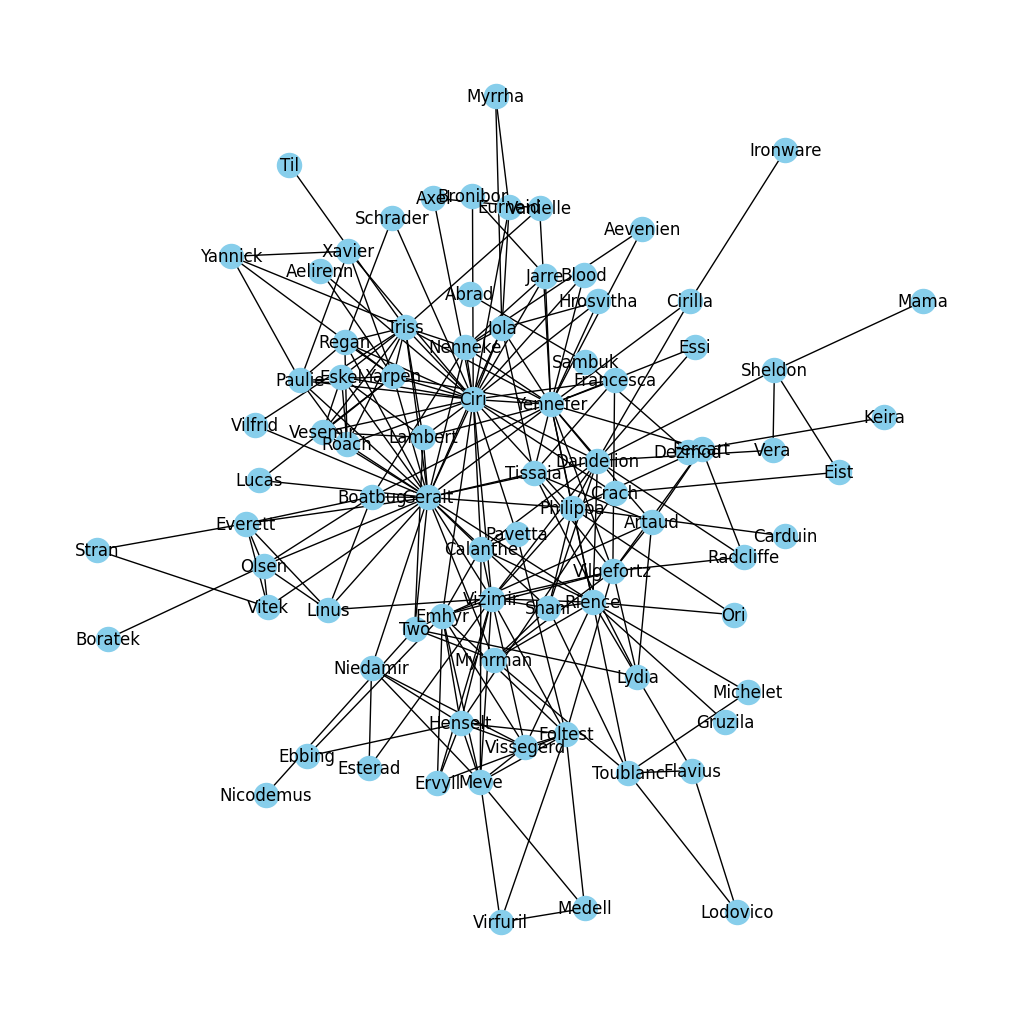

In [32]:
import scipy
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Graph visualization - Pyvis

In [35]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### The most important characters in The Witcher

In [36]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Ciri': 0.3536585365853659,
 'Geralt': 0.3536585365853659,
 'Dandelion': 0.15853658536585366,
 'Yennefer': 0.2804878048780488,
 'Cirilla': 0.03658536585365854,
 'Vera': 0.024390243902439025,
 'Pavetta': 0.03658536585365854,
 'Calanthe': 0.0975609756097561,
 'Ironware': 0.012195121951219513,
 'Eist': 0.024390243902439025,
 'Sheldon': 0.04878048780487805,
 'Radcliffe': 0.03658536585365854,
 'Dezmod': 0.012195121951219513,
 'Sambuk': 0.024390243902439025,
 'Abrad': 0.012195121951219513,
 'Mama': 0.012195121951219513,
 'Gruzila': 0.012195121951219513,
 'Rience': 0.17073170731707318,
 'Niedamir': 0.06097560975609756,
 'Vizimir': 0.1951219512195122,
 'Eskel': 0.07317073170731708,
 'Roach': 0.07317073170731708,
 'Vesemir': 0.07317073170731708,
 'Triss': 0.17073170731707318,
 'Lambert': 0.08536585365853659,
 'Til': 0.012195121951219513,
 'Two': 0.07317073170731708,
 'Nenneke': 0.0975609756097561,
 'Vanielle': 0.03658536585365854,
 'Axel': 0.024390243902439025,
 'Fercart': 0.07317073170731708,

In [39]:
degree_df.head()

,centrality
Ciri,0.353659
Geralt,0.353659
Dandelion,0.158537
Yennefer,0.280488
Cirilla,0.036585


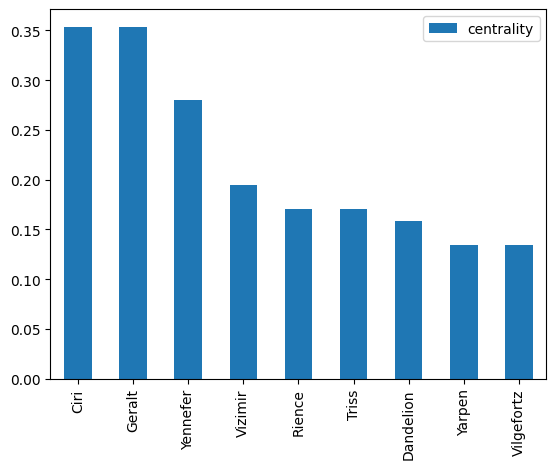

In [38]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar");

<AxesSubplot: >

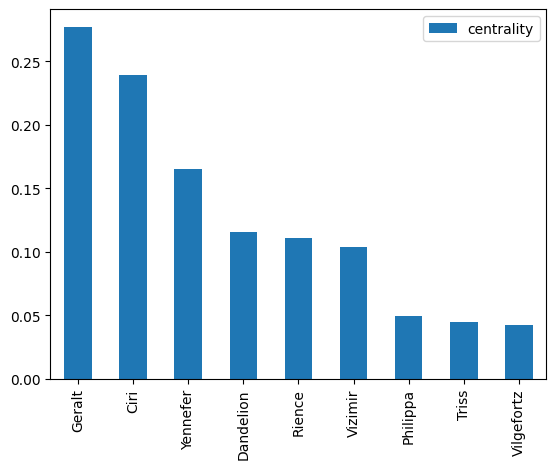

In [41]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

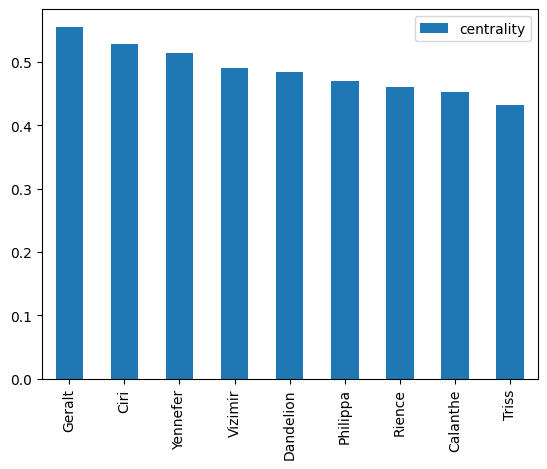

In [43]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar");